# 4 - AutoEncoders

In [1]:
# %pip install kagglehub
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("zalando-research/fashionmnist")

# print("Path to dataset files:", path)

In [2]:
%pip install -q tensorflow



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 4 - 1 Normalization and Preprocessing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.datasets import mnist

In [4]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))



In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, datasets

class Auto_Encoder:
    def __init__(self, encoder_layers, decoder_layers, latent_dimensions):
        # Build encoder
        self.encoder = tf.keras.Sequential()
        self.encoder.add(layers.Input(shape=(28, 28, 1)))
        self.encoder.add(layers.Flatten())
        
        for _ in range(encoder_layers):
            self.encoder.add(layers.Dense(latent_dimensions * 2, activation='relu'))
        self.encoder.add(layers.Dense(latent_dimensions, activation='relu'))  # latent layer
        

        self.decoder = tf.keras.Sequential()
        for _ in range(decoder_layers):
            self.decoder.add(layers.Dense(latent_dimensions * 2, activation='relu'))
        self.decoder.add(layers.Dense(28 * 28, activation='relu'))
        self.decoder.add(layers.Reshape((28, 28, 1)))
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def train(self, X_train, n_epochs=10, batch_size=64, learning_rate=0.001):
        train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1024).batch(batch_size)
        loss_fn = losses.MeanSquaredError()
        optimizer = optimizers.AdamW(learning_rate=learning_rate)
        
        for epoch in range(n_epochs):
            print(f"\nEpoch {epoch + 1}/{n_epochs}")
            epoch_loss = tf.metrics.Mean()

            for batch in train_dataset:
                with tf.GradientTape() as tape:
                    reconstructed = self.forward(batch)
                    loss = loss_fn(batch, reconstructed)

                grads = tape.gradient(
                    loss,
                    self.encoder.trainable_variables + self.decoder.trainable_variables
                )
                optimizer.apply_gradients(
                    zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables)
                )

                epoch_loss.update_state(loss)

            print(f"Training Loss: {epoch_loss.result()}")



In [6]:

tf.config.optimizer.set_jit(True)
auto_encoder = Auto_Encoder(encoder_layers=3, decoder_layers=3, latent_dimensions=128)
auto_encoder.train(n_epochs = 5, batch_size=128, learning_rate = 0.001, X_train = X_train)
encoded_imgs = auto_encoder.encoder(X_test).numpy()
decoded_imgs = auto_encoder.decoder(encoded_imgs).numpy()




Epoch 1/5
Training Loss: 0.03794395178556442

Epoch 2/5
Training Loss: 0.02163585089147091

Epoch 3/5
Training Loss: 0.01879117637872696

Epoch 4/5
Training Loss: 0.0176940206438303

Epoch 5/5
Training Loss: 0.016925010830163956


### Display images of different classes

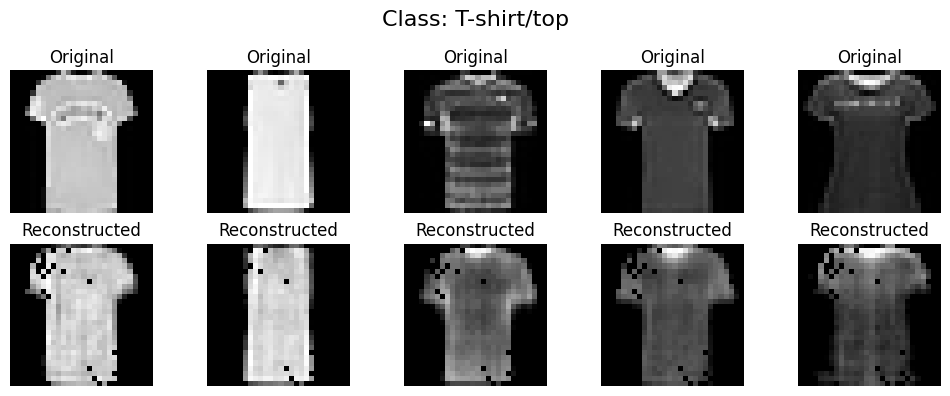

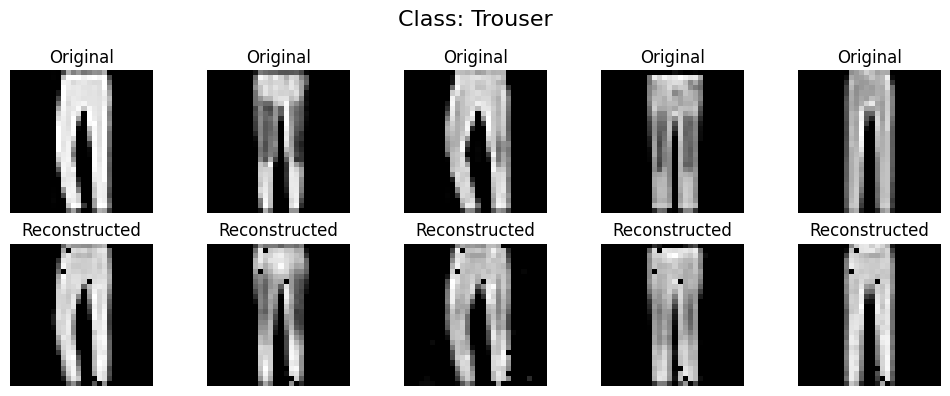

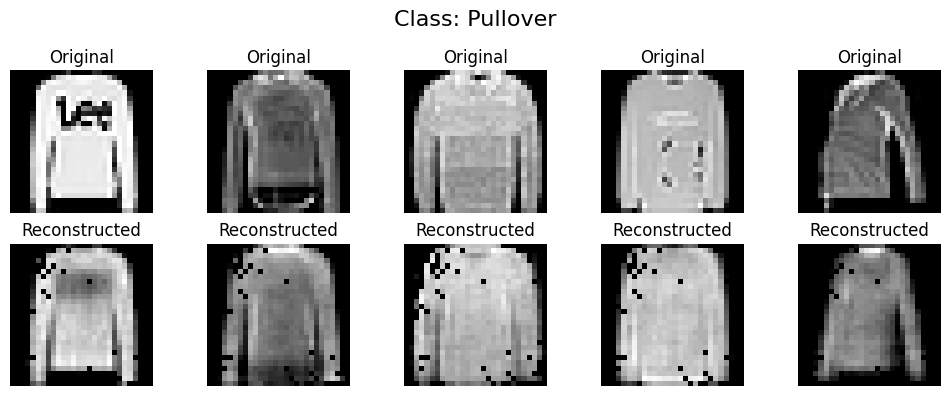

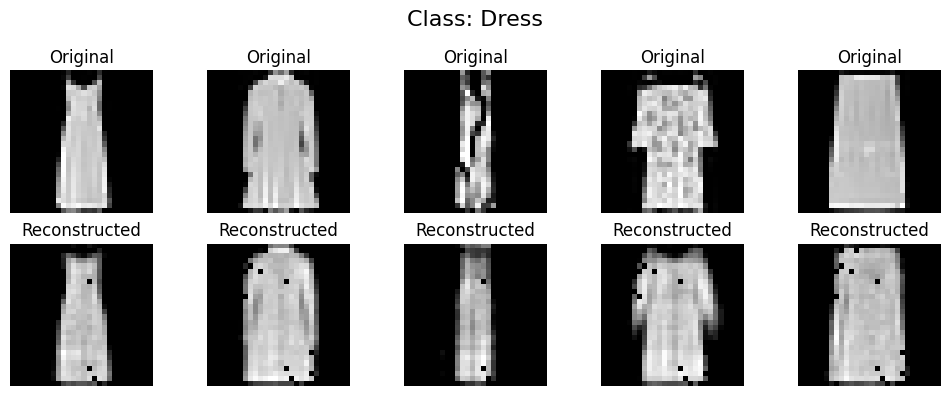

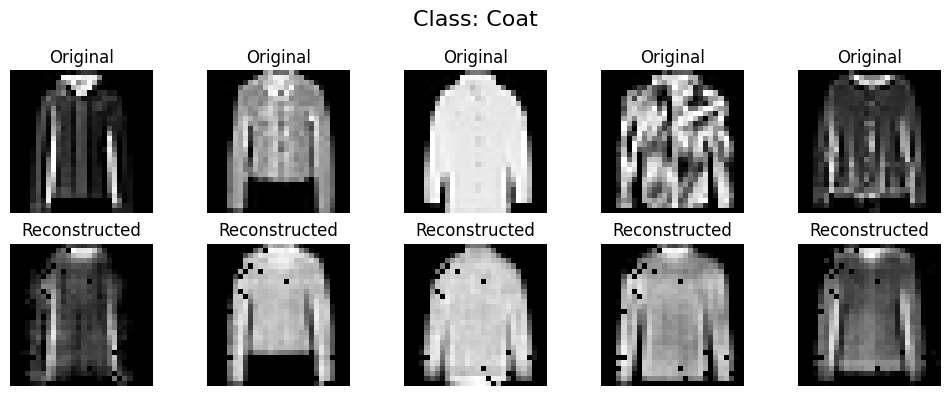

In [7]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

chosen_classes = [0, 1, 2, 3, 4]
decoded_imgs = auto_encoder.forward(X_test).numpy()

for class_id in chosen_classes:
    indices = np.where(y_test == class_id)[0][:5]

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Class: {class_names[class_id]}", fontsize=16)

    for j, i in enumerate(indices):
        # Original
        ax = plt.subplot(2, 5, j + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, 5, j + 6)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



### Cluster encoded data using K-means

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Step 1️⃣ — Get encoded representations (latent vectors)
encoded_data = auto_encoder.encoder(X_test).numpy()   # shape: (num_samples, latent_dim)

print("Encoded data shape:", encoded_data.shape)

# Step 2️⃣ — Run K-Means clustering on the latent space
kmeans = KMeans(n_clusters=10, n_init=50, random_state=0)
kmeans.fit(encoded_data)


Encoded data shape: (10000, 128)


KMeans(n_clusters=10, n_init=50, random_state=0)

In [9]:
from sklearn.cluster import KMeans

# Cluster the latent features
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(encoded_imgs)


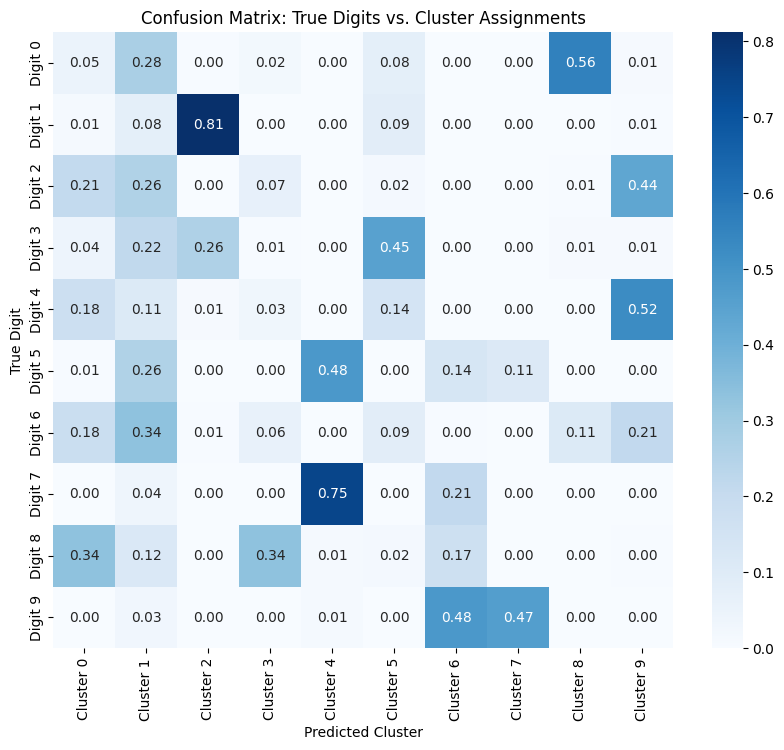

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, cluster_labels)

# Normalize confusion matrix for better interpretability (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"Cluster {i}" for i in range(n_clusters)],
            yticklabels=[f"Digit {i}" for i in range(10)])
plt.xlabel("Predicted Cluster")
plt.ylabel("True Digit")
plt.title("Confusion Matrix: True Digits vs. Cluster Assignments")
plt.show()


In [11]:
from scipy.stats import mode
cluster_to_digit = {}
for cluster in range(n_clusters):
    mask = cluster_labels == cluster
    if np.any(mask):
        cluster_to_digit[cluster] = mode(y_test[mask], keepdims=True)[0][0]

print("Cluster to Digit Mapping:")
print(cluster_to_digit)


Cluster to Digit Mapping:
{0: 8, 1: 6, 2: 1, 3: 8, 4: 7, 5: 3, 6: 9, 7: 9, 8: 0, 9: 4}


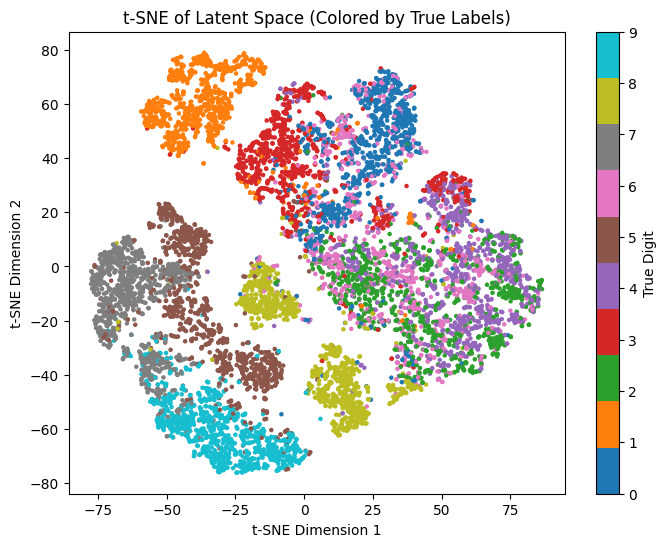

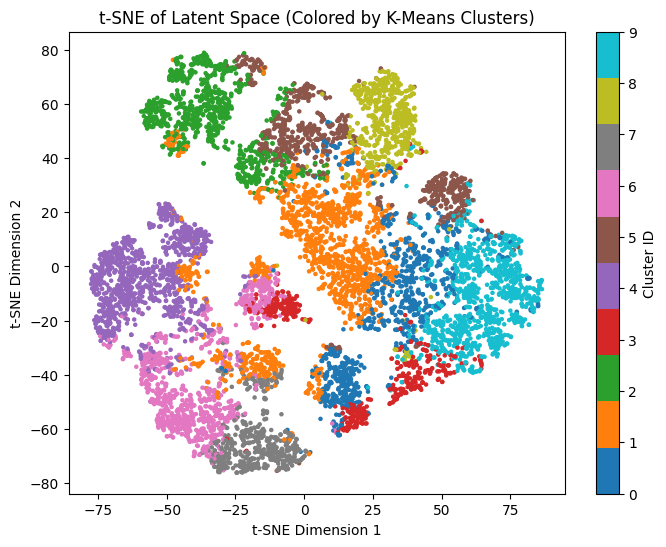

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce latent vectors (encoded_imgs) to 2D with t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
encoded_tsne = tsne.fit_transform(encoded_imgs)

# Plot 1: color by true labels
plt.figure(figsize=(8, 6))
scatter1 = plt.scatter(encoded_tsne[:, 0], encoded_tsne[:, 1],
                       c=y_test, cmap='tab10', s=5)
plt.colorbar(scatter1, ticks=range(10), label="True Digit")
plt.title("t-SNE of Latent Space (Colored by True Labels)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Plot 2: color by K-Means cluster assignment
plt.figure(figsize=(8, 6))
scatter2 = plt.scatter(encoded_tsne[:, 0], encoded_tsne[:, 1],
                       c=cluster_labels, cmap='tab10', s=5)
plt.colorbar(scatter2, ticks=range(10), label="Cluster ID")
plt.title("t-SNE of Latent Space (Colored by K-Means Clusters)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


### TSNE, KMEANS AND CONFUSION MATRIX FOR RAW Un-encoded data

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
X_test= X_test.reshape(len(X_test), -1)
n_clusters = 10
kmeans_raw = KMeans(n_clusters=n_clusters, n_init=20, random_state=10)
cluster_labels_raw = kmeans_raw.fit_predict(X_test)

cluster_to_digit_raw = {}
for cluster in range(n_clusters):
    mask = cluster_labels_raw == cluster
    if np.any(mask):
        cluster_to_digit_raw[cluster] = mode(y_test[mask], keepdims=True)[0][0]

print("Cluster → Digit Mapping (Raw Data):")
print(cluster_to_digit_raw)

Cluster → Digit Mapping (Raw Data):
{0: 8, 1: 5, 2: 1, 3: 2, 4: 9, 5: 7, 6: 0, 7: 4, 8: 6, 9: 8}


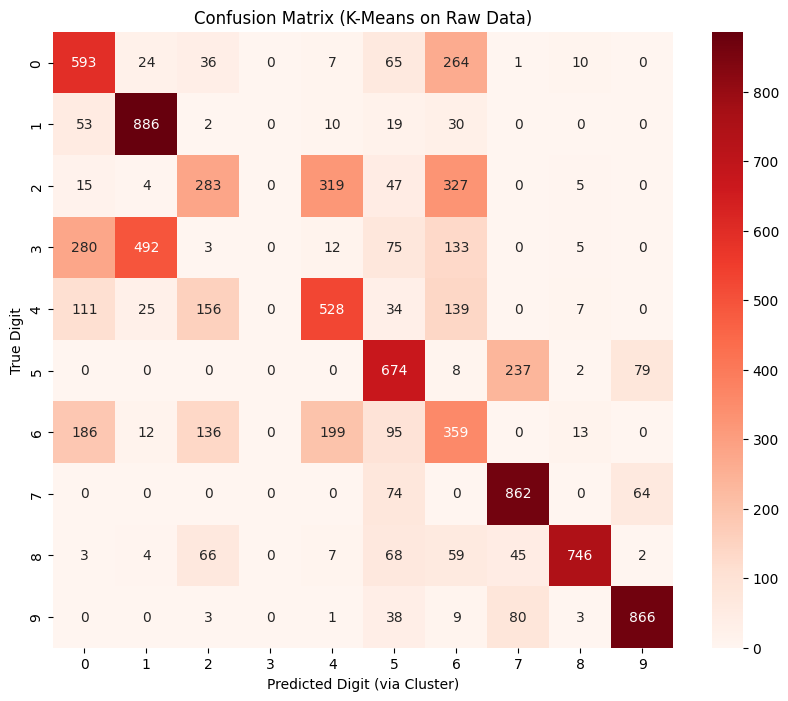

In [14]:
mapped_preds_raw = np.array([cluster_to_digit_raw[c] for c in cluster_labels_raw])
cm_raw = confusion_matrix(y_test, mapped_preds_raw)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_raw, annot=True, fmt="d", cmap="Reds",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel("Predicted Digit (via Cluster)")
plt.ylabel("True Digit")
plt.title("Confusion Matrix (K-Means on Raw Data)")
plt.show()

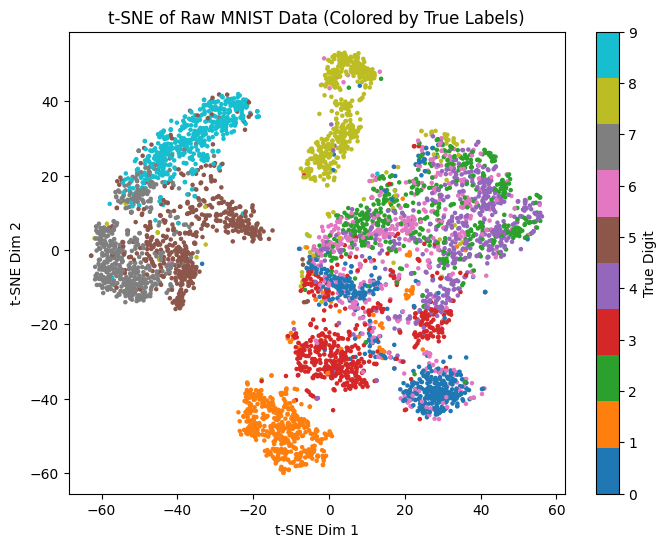

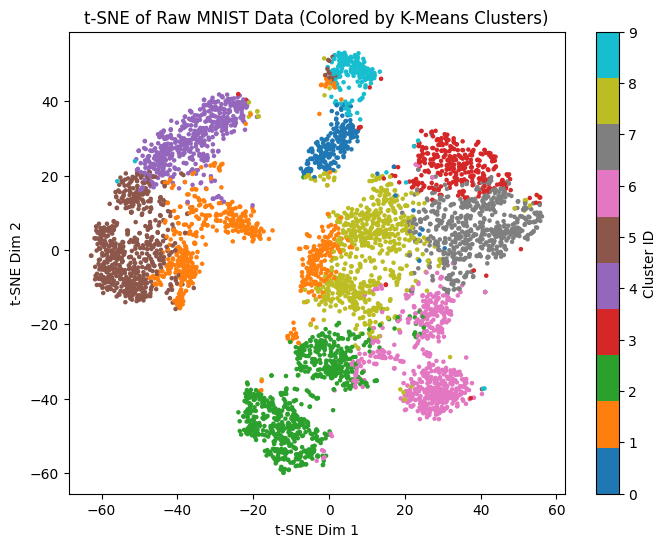

In [15]:
subset_size = 5000
idx = np.random.choice(len(X_test), subset_size, replace=False)
X_subset = X_test[idx]
y_subset = y_test[idx]
cluster_subset = cluster_labels_raw[idx]

tsne_raw = TSNE(n_components=2, perplexity=50, learning_rate=200, random_state=42)
X_tsne_raw = tsne_raw.fit_transform(X_subset)

plt.figure(figsize=(8, 6))
scatter1 = plt.scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1],
                       c=y_subset, cmap='tab10', s=5)
plt.colorbar(scatter1, ticks=range(10), label="True Digit")
plt.title("t-SNE of Raw MNIST Data (Colored by True Labels)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

plt.figure(figsize=(8, 6))
scatter2 = plt.scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1],
                       c=cluster_subset, cmap='tab10', s=5)
plt.colorbar(scatter2, ticks=range(10), label="Cluster ID")
plt.title("t-SNE of Raw MNIST Data (Colored by K-Means Clusters)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()